# 3.1 MNIST

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784",version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X,y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

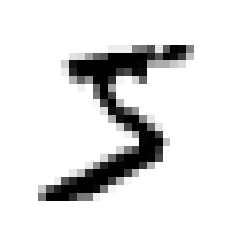

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
import numpy as np
y = y.astype(np.uint8)

In [6]:
X_train, y_train, X_test,y_test = X[:60000],y[:60000],X[60000:],y[60000:]

# 3.2 이진 분류기 훈련

In [7]:
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit])

array([ True])

# 3.3 성능측정

## 3.3.1 교차검증을 사용한 정확도 측정

- 교차검증 구현

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


- cross_val_score()로 kfold cross validation

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train,y_train_5,cv=3,scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X,y=None):
        return self
    def predict(self,X):
        return np.zeros((len(X),1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train,y_train_5,cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [14]:
class FiveClassifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self,X):
        return np.ones((len(X),1), dtype=bool)
_5_clf = FiveClassifier()
cross_val_score(_5_clf, X_train,y_train_5,cv=3,scoring="accuracy")

array([0.08875, 0.09145, 0.09085])

## 3.3.2 오차행렬 confusion_matrix
- 클래스 A의 샘플이 클래스 B로 분류된 횟수를 셈

In [15]:
# 예측값 생성
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train,y_train_5,cv=3)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

## 3.3.3 정밀도와 재현율

In [17]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [18]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

decision_function()을 통해 샘플의 점수를 구한 후, 임계값(threshold)설정

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [21]:
threshold=0
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([ True])

In [22]:
threshold = 8000
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([False])

적절한 임계값 찾기 >> 모든 훈련세트에 있는 모든 샘플의 점수를 계산해야함

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train,y_train_5, cv=3,method="decision_function") # 모든 샘플의 점수

precision_recall_curve()를 통해 모든 임계값에 대한 정밀도와 재현율 계산

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

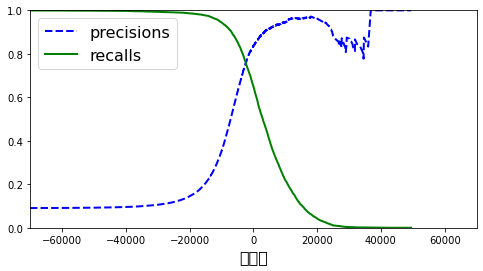

In [25]:

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precisions", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="recalls", linewidth=2)
    plt.xlabel("임계값", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-70000, 70000])
#save_fig("precision_recall_vs_threshold_plot")
plt.show()

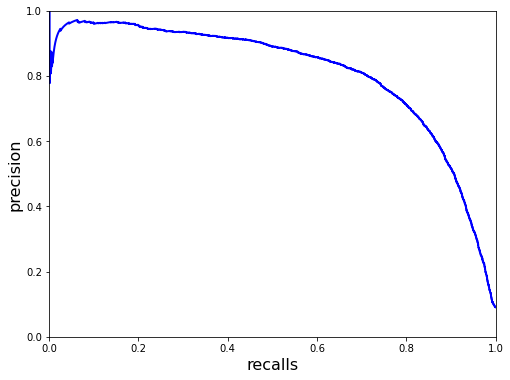

In [26]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("recalls", fontsize=16)
    plt.ylabel("precision", fontsize=16)
    plt.axis([0,1,0,1])
    
plt.figure(figsize=(8,6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

정밀도 90%

In [27]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]
threshold_90_precision

3370.0194991439594

In [28]:
y_scores # 모든 샘플의 점수

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [29]:
y_train_pred_90 = (y_scores >= threshold_90_precision) # 모든 샘플의 점수중에서 threshold_90_precision인것만 True
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [30]:
precision_score(y_train_5, y_train_pred_90) # 정확도 측정

0.9000345901072293

In [31]:
recall_score(y_train_5, y_train_pred_90) # 재현율 측정

0.4799852425751706

## 3.3.5 ROC 곡선

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

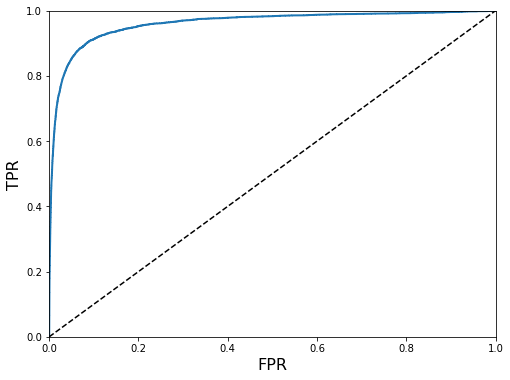

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel("FPR", fontsize=16)
    plt.ylabel("TPR", fontsize=16)
    
plt.figure(figsize=(8,6))
plot_roc_curve(fpr,tpr)
plt.show()

In [34]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

- RandomForestClassifier의 ROC, AUC와 SGDClassifier의 비교

In [35]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [36]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

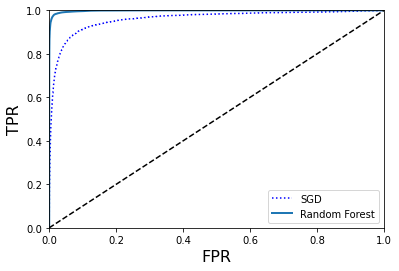

In [37]:
plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")
plt.legend(loc="lower right")
plt.show()

In [38]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# 3.4 다중분류

In [39]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train,y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [40]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [41]:
np.argmax(some_digit_scores)

5

In [42]:
svm_clf.classes_[5]

5

- OvO 강제 >> OneVsOneClassifier   
- OvR 강제 >> OneVsRestClassifier

In [56]:
# SVC 기반 OvR전략을 사용하는 다중 분류기
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train,y_train)
ovr_clf.predict([some_digit])
len(ovr_clf.estimators_)

10

- SGD 분류기는 직접 샘플을 다중 클래스로 분류가능 >> OvO, OvR적용할 필요 없음

In [43]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [44]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [45]:
cross_val_score(sgd_clf, X_train,y_train,cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train,cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# 3.5  에러분석
- 성능향삭 방법 >> 에러의 종류 분석

In [47]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train,cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx
    

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

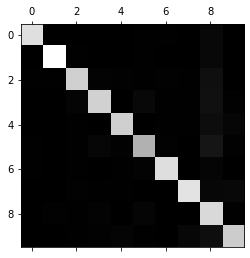

In [48]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

In [49]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

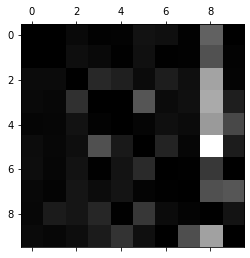

In [50]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [51]:
import matplotlib
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

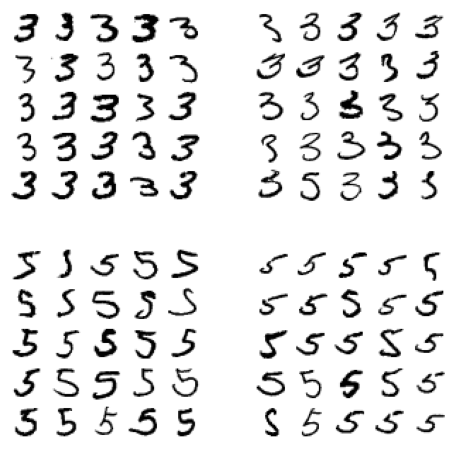

In [52]:
cl_a, cl_b = 3,5
X_aa = X_train[(y_train==cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train==cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train==cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train==cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()


# 3.6 다중 레이블 분류
- 여러 개의 이진 꼬리표를 출력하는 분류 시스템

In [53]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train>=7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier()

In [54]:
knn_clf.predict([some_digit])

array([[False,  True]])

- 다중 레이블 분류기 평가

In [55]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred,average="macro")

0.976410265560605

# 3.7 다중 출력 분류
- 다중 레이블 분류에서 한 레이블이 다중 클래스. 즉 0,1만 갖는것이 아니라 0,1,2,..를 가질 수 있음

In [57]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [58]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

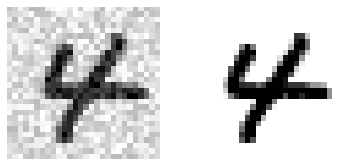

In [59]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
#save_fig("noisy_digit_example_plot")
plt.show()

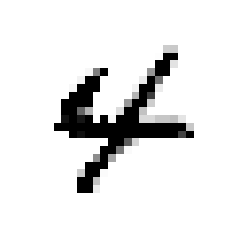

In [60]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

# 연습문제 1. 정확도 97%의 MNIST 분류기

In [61]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {"weights":["uniform", "distance"],
     "n_neighbors":[3,4,5]}
]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  30 | elapsed: 44.1min remaining: 220.3min
[Parallel(n_jobs=-1)]: Done  16 out of  30 | elapsed: 44.9min remaining: 39.3min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 56.3min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 56.3min finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [62]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [63]:
grid_search.best_score_

0.9716166666666666

In [64]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test,y_pred)

0.9714

# 연습문제 2. 데이터 증식

In [65]:
from scipy.ndimage.interpolation import shift

In [66]:
def shift_image(image,dx,dy):
    image = image.reshape((28,28))
    shifted_image = shift(image,[dy,dx],cval=0, mode="constant")
    return shifted_image.reshape([-1])

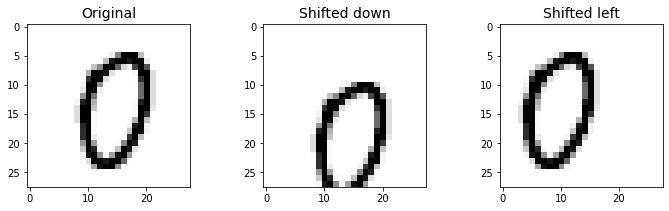

In [67]:
image = X_train[1000]
shifted_image_down = shift_image(image,0,5)
shifted_image_left = shift_image(image,-5,0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28,28),interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28,28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28,28), interpolation="nearest", cmap="Greys")

In [68]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1,0), (-1,0), (0,1),(0,-1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image,dx,dy))
        y_train_augmented.append(label)
        
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [69]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [70]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [93]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [94]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test,y_pred)

KeyboardInterrupt: 